<img style="float: left;" src="figures/model4.png" width="25%">


# <font color='Red'> GCS in auquifers </font>

## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D aquifer.

## <font color='blue'>The objectives:</font>
Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [CompositionalPhysics](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/physics.py) for compositional physics
 * Class [PropertyContainer](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/property_container.py) for allocating property evaluators needed in simulation
 * Class [CompositionalOperators](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/operator_evaluator.py) for defining OBL operators in simulation
 
 
Inject CO$_2$ for 2 years and monitor for another 10


## <font color='blue'>Let's start !</font>
### We need to import <font color='red'>engines</font> and nessesary physical properties into the workspace, just like the import of commonly-used modules such as numpy etc.

In [1]:
'''Import all important packages from DARTS installation'''
import numpy as np
import pandas as pd
import sys
from darts.engines import value_vector, redirect_darts_output, sim_params
import matplotlib.pyplot as plt

from darts.reservoirs.struct_reservoir import StructReservoir
from darts.models.darts_model import DartsModel

from darts.physics.super.physics import Compositional
from darts.physics.super.property_container import PropertyContainer
from darts.physics.super.operator_evaluator import PropertyOperators

from darts.physics.properties.flash import ConstantK
from darts.physics.properties.basic import ConstFunc, PhaseRelPerm
from darts.physics.properties.density import DensityBasic

## <font color='Blue'>Brief Introduction of model inheritance:</font>

* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self):
        # Call base class constructor
        super().__init__()

        # Measure time spend on reading/initialization
        self.timer.node["initialization"].start()

    def set_reservoir(self):
        nx = 1000
        ny = 1
        nz = 50
        nb = nx * ny * nz
        self.dx = 5
        self.dz = 1
        depth = np.zeros(nb)
        n_layer = nx*ny
        for k in range(nz):
            depth[k*n_layer:(k+1)*n_layer] = 2000 + k * self.dz


        reservoir = StructReservoir(self.timer, nx, ny, nz, dx=self.dx, dy=100, dz=self.dz,
                                    permx=100, permy=100, permz=10, poro=0.2, depth=depth)

        res = super().set_reservoir(reservoir)
        
        volume = np.array(reservoir.mesh.volume, copy=False)
        poro = np.array(reservoir.mesh.poro, copy=False)
        print("Pore volume = " + str(sum(volume * poro)))

        # add large volume to teh last layer to mimic a large auifer
        volume[-1:] = 1e8

        return res

    def set_wells(self, name='I'):
        nz = self.reservoir.nz

        self.reservoir.add_well(name)
        # add well to teh middle of active zone
        self.reservoir.add_perforation(name, cell_index=(1, 1, nz), well_radius=0.1, well_indexD=0)

        return super().set_wells()

    def set_physics(self):
        """Physical properties"""
        self.zero = 1e-12
        # Create property containers:
        components = ['CO2', 'H2O']
        phases = ['gas', 'wat']
        thermal = 0
        Mw = [44.01, 18.015]

        property_container = PropertyContainer(phases_name=phases, components_name=components,
                                               Mw=Mw, min_z=self.zero / 10, temperature=1.)

        """ properties correlations """
        property_container.flash_ev = ConstantK(len(components), [80, 1e-2], self.zero)
        property_container.density_ev = dict([('gas', DensityBasic(compr=1e-3, dens0=200)),
                                              ('wat', DensityBasic(compr=1e-5, dens0=900))])
        property_container.viscosity_ev = dict([('gas', ConstFunc(0.05)),
                                                ('wat', ConstFunc(0.5))])
        property_container.rel_perm_ev = dict([('gas', PhaseRelPerm("gas", sgr=0.1)),
                                               ('wat', PhaseRelPerm("oil", swc=0.25))])

        """ Activate physics """
        physics = Compositional(components, phases, self.timer,
                                n_points=200, min_p=1, max_p=400, min_z=self.zero/10, max_z=1-self.zero/10)
        physics.add_property_region(property_container)
        
        # additional properties to report
        props = [('Brine saturation', 'sat', 1), ('Gas saturation', 'sat', 0)]
        physics.add_property_operators(PropertyOperators(props, property_container))

        return super().set_physics(physics)

    def set_well_controls(self):
        # inejct pure CO2
        self.inj_stream = [1.0 - self.zero]
        
        # two types of well control
        for i, w in enumerate(self.reservoir.wells):
            if 'I' in w.name:
                w.control = self.physics.new_rate_inj(1000, self.inj_stream, 0)
                w.constraint = self.physics.new_bhp_inj(300, self.inj_stream)
            else:
                w.control = self.physics.new_rate_prod(1000, 0)
                w.constraint = self.physics.new_bhp_prod(30)


In [3]:
def plot2D(m):    
    nx = m.reservoir.nx
    nz = m.reservoir.nz

    x = np.linspace(0, nx * m.dx, nx)
    y = np.linspace(nz * m.dz, 0, nz)
    
    properties = m.physics.vars + m.physics.property_operators.props_name
    output = m.output_properties()        

    plt.rcParams['pcolor.shading'] ='nearest'
    print_props = [0, 1, 3]
    
    fig, axs = plt.subplots(len(print_props), 1, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
    for i, ith_prop in enumerate(print_props):
        # plot array defined in active cells only
        arr = output[ith_prop, :]
        prop = axs[i].pcolor(x, y, arr.reshape(nz, nx))
        plt.colorbar(prop, ax=axs[i]) 
        axs[i].set_title(properties[ith_prop])
        axs[i].axis('off')        
    
    plt.tight_layout()

In [4]:
m = Model()
m.set_reservoir()
m.set_wells()
m.set_physics()
m.set_sim_params(first_ts=0.001, mult_ts=2, max_ts=31, runtime=1000, tol_newton=1e-2, tol_linear=1e-3,
                 it_newton=12, it_linear=50, newton_type=sim_params.newton_local_chop)


m.initial_values = {m.physics.vars[0]: 200,
                    m.physics.vars[1]: m.zero}

m.init()

darts-package built on 03/12/2023 15:29:52 by SRV554$@SRV554 from 688ff7e1-dirty
Building connection list...
Pore volume = 5000000.0


In [5]:
# run simulation for a year
m.run_python(2*365)

# print statistics and timers
m.print_timers()
m.print_stat()

# 1 	T = 0.001	DT = 0.001	NI = 4	LI=7
# 2 	T = 0.003	DT = 0.002	NI = 2	LI=8
# 3 	T = 0.007	DT = 0.004	NI = 2	LI=8
# 4 	T = 0.015	DT = 0.008	NI = 2	LI=9
# 5 	T = 0.031	DT = 0.016	NI = 2	LI=8
# 6 	T = 0.063	DT = 0.032	NI = 3	LI=12
# 7 	T = 0.127	DT = 0.064	NI = 4	LI=21
# 8 	T = 0.255	DT = 0.128	NI = 5	LI=28
# 9 	T = 0.511	DT = 0.256	NI = 4	LI=20
# 10 	T = 1.023	DT = 0.512	NI = 5	LI=23
# 11 	T = 2.047	DT = 1.024	NI = 6	LI=36
# 12 	T = 4.095	DT = 2.048	NI = 6	LI=33
# 13 	T = 8.191	DT = 4.096	NI = 7	LI=46
# 14 	T = 16.383	DT = 8.192	NI = 7	LI=46
# 15 	T = 32.767	DT = 16.384	NI = 8	LI=55
# 16 	T = 63.767	DT = 31	NI = 7	LI=51
# 17 	T = 94.767	DT = 31	NI = 7	LI=45
# 18 	T = 125.767	DT = 31	NI = 7	LI=45
# 19 	T = 156.767	DT = 31	NI = 6	LI=40
# 20 	T = 187.767	DT = 31	NI = 6	LI=39
# 21 	T = 218.767	DT = 31	NI = 6	LI=37
# 22 	T = 249.767	DT = 31	NI = 6	LI=37
# 23 	T = 280.767	DT = 31	NI = 5	LI=32
# 24 	T = 311.767	DT = 31	NI = 6	LI=39
# 25 	T = 342.767	DT = 31	NI = 6	LI=38
# 26 	T = 373.767	DT = 

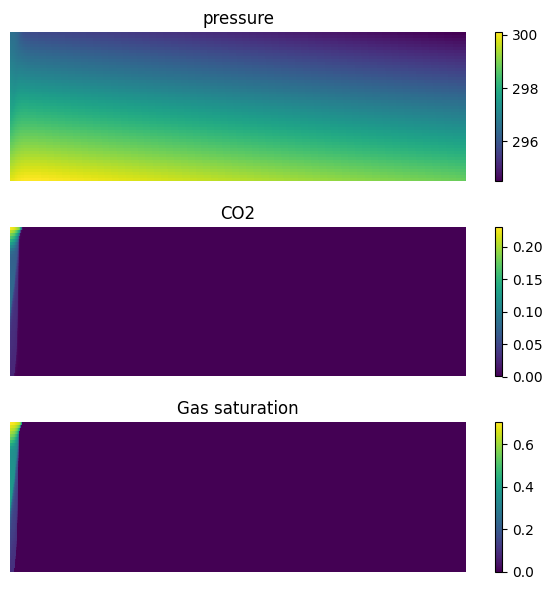

In [6]:
plot2D(m)
plt.show()

In [7]:
m.reservoir.wells[0].control = m.physics.new_rate_inj(0, m.inj_stream, 0)
m.params.max_ts = 93
m.run_python(3650)

# 1 	T = 823	DT = 93	NI = 11	LI=83
# 2 	T = 916	DT = 93	NI = 8	LI=56
# 3 	T = 1009	DT = 93	NI = 7	LI=54
# 4 	T = 1102	DT = 93	NI = 6	LI=47
# 5 	T = 1195	DT = 93	NI = 7	LI=49
# 6 	T = 1288	DT = 93	NI = 6	LI=39
# 7 	T = 1381	DT = 93	NI = 7	LI=41
# 8 	T = 1474	DT = 93	NI = 5	LI=36
# 9 	T = 1567	DT = 93	NI = 5	LI=35
# 10 	T = 1660	DT = 93	NI = 5	LI=35
# 11 	T = 1753	DT = 93	NI = 5	LI=34
# 12 	T = 1846	DT = 93	NI = 5	LI=32
# 13 	T = 1939	DT = 93	NI = 4	LI=28
# 14 	T = 2032	DT = 93	NI = 4	LI=27
# 15 	T = 2125	DT = 93	NI = 5	LI=35
# 16 	T = 2218	DT = 93	NI = 5	LI=32
# 17 	T = 2311	DT = 93	NI = 4	LI=28
# 18 	T = 2404	DT = 93	NI = 4	LI=27
# 19 	T = 2497	DT = 93	NI = 4	LI=28
# 20 	T = 2590	DT = 93	NI = 3	LI=20
# 21 	T = 2683	DT = 93	NI = 4	LI=28
# 22 	T = 2776	DT = 93	NI = 3	LI=21
# 23 	T = 2869	DT = 93	NI = 5	LI=34
# 24 	T = 2962	DT = 93	NI = 4	LI=27
# 25 	T = 3055	DT = 93	NI = 4	LI=24
# 26 	T = 3148	DT = 93	NI = 3	LI=21
# 27 	T = 3241	DT = 93	NI = 3	LI=22
# 28 	T = 3334	DT = 93	NI = 3	LI=19
# 

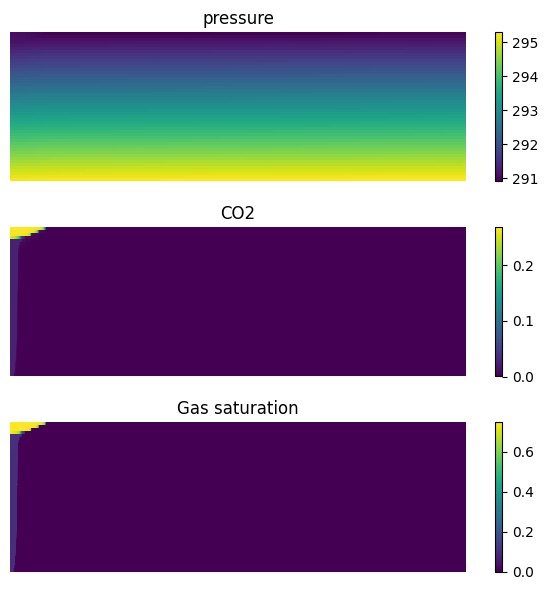

In [8]:
plot2D(m)
plt.show()